In [148]:
from sklearn.datasets import make_blobs, make_moons
import torch
from torch import nn
import pandas as pd
import seaborn as sns
import seaborn
from torch.optim import SGD
import torch.nn.functional as F
import numpy as np

RANDOM_STATE = 45

np.random.seed(RANDOM_STATE)

import matplotlib.pyplot as plt
%matplotlib inline

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


def plot_decision_boundry(net, X, line='g--'):
    W = net.fc.weight[0].detach().cpu().numpy()
    b = net.fc.bias.detach().cpu().numpy()
    f = lambda x: (-W[0]/W[1]) * x +  (-b/W[1])
    dziedz = np.arange(-1, 1, 0.01)
    plt.plot(dziedz, f(dziedz), line) 
    plt.xlim((-2, 2))
    plt.ylim((-2, 2))

# Prepare and Visualize data

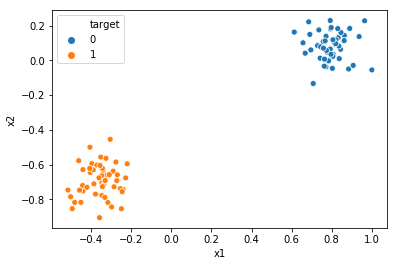

In [149]:
N_FEATURES = 2


X, Y = make_blobs(centers=2, center_box=(-10, 10), random_state=RANDOM_STATE, n_features=N_FEATURES)
# X, Y = make_moons()

X = X/np.abs(X).max()
# Y_one_hot = ohe.fit_transform(Y.reshape(-1, 1)).toarray()

data = pd.DataFrame(X, columns=['x1', 'x2'])
data['target'] = Y
seaborn.scatterplot(x='x1',y='x2', hue='target', data=data)

In [150]:
pd.DataFrame(X, columns = ['A', 'B']).head()

,A,B
0,0.707380,-0.133517
1,-0.316867,-0.817494
2,0.792607,0.064959
3,-0.323771,-0.660196
4,-0.405178,-0.645079


In [151]:
pd.DataFrame(Y, columns = ['Y']).head()

,Y
0,0
1,1
2,0
3,1
4,1


# Define the perceptron


![alt text](https://i.stack.imgur.com/2MVdW.png "Title")


In [152]:
input_tensor = torch.randn((1, 2))
linear_layer = nn.Linear(2, 1)
linear_layer(input_tensor)

print(input_tensor)
print(linear_layer.weight)
print(linear_layer.bias)
print(linear_layer(input_tensor))
print(f'Manual computation: {np.dot(linear_layer.weight.detach().numpy(), input_tensor.detach().numpy().transpose()) + linear_layer.bias.detach().numpy()}')

tensor([[1.5964, 0.4434]])
Parameter containing:
tensor([[-0.5960, -0.4890]], requires_grad=True)
Parameter containing:
tensor([0.2177], requires_grad=True)
tensor([[-0.9506]], grad_fn=<AddmmBackward>)
Manual computation: [[-0.9505534]]


In [153]:
class Perceptron(nn.Module):
    def __init__(self, n_in, n_out):

        super(Perceptron, self).__init__()
        self.fc = nn.Linear(n_in, n_out, bias=True)
        #self.fc1 = nn.Linear(n_in, 4, bias = True)
        #self.fc = nn.Linear(4, n_out, bias = True)
    
    def forward(self, x):
        #x = self.fc1(x)
        return F.relu(self.fc(x))
        #return F.relu(self.fc(x))

def custom_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.05)
        
def custom_weights_zero(m):
    if type(m) == nn.Linear:
        torch.nn.init.constant(m.weight, 0.0)
        m.bias.data.fill_(0.0)
        
perceptron = Perceptron(2, 1)

# Linear layers get their weights initialized by default, but you can reinitialize them if needed.
perceptron.apply(custom_weights)
#perceptron.apply(custom_weights_zero)

print("fc weight", perceptron.fc.weight)
print("bias weight", perceptron.fc.bias)

fc weight Parameter containing:
tensor([[-1.2424, -0.1213]], requires_grad=True)
bias weight Parameter containing:
tensor([0.0500], requires_grad=True)


/opt/conda/envs/dsr/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  app.launch_new_instance()


# Train Loop Using CrossEntropy



While using crossentropy loss our model needs to return (BS, n_classes) output tensor, the target has to be a coresponding dense label vector of shape (BS, 1)

In [154]:
my_net = perceptron
A = list(my_net.parameters())
print(A[0])
print(A[1])

Parameter containing:
tensor([[-1.2424, -0.1213]], requires_grad=True)
Parameter containing:
tensor([0.0500], requires_grad=True)



input shape (BS, n_classes): torch.Size([1, 2])
target shape (BS, 1): torch.Size([1, 1])
output shape torch.Size([1, 1])


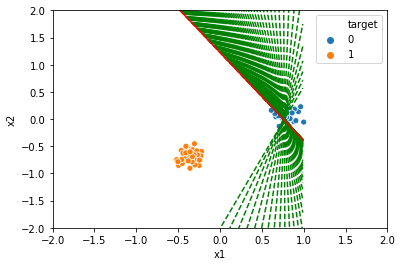

In [158]:
from tqdm import tqdm_notebook as tqdm

N_EPOCHS = 100

# init the model, loss and optimizer
net = Perceptron(2, 1)
optimizer = SGD(net.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss() # Sigmoid also done in loss, not in activation, because numer. more stable

net = net.to(DEVICE)

loss_history = []

with tqdm(total=N_EPOCHS) as pbar:

    for epoch in range(N_EPOCHS):

        #print("training epoch {}".format(epoch))
        pbar.update(1)
        pbar.set_description('processed: %d' % (1 + epoch))

        for xsample,ysample in zip(X, Y):

            # zero the gradients at start of every mini-batch, otherwise would accumulate
            optimizer.zero_grad() 

            # batch preparation
            x = torch.Tensor(xsample).unsqueeze(0) # tensor([[0.8745, 0.5205]]) torch.Size([1, 2])
            y = torch.Tensor([ysample]).unsqueeze(0) # tensor([[1.]]) torch.Size([1, 1])
            x = x.to(DEVICE) # moves data to device
            y = y.to(DEVICE) # moves data to device

            # forward pass
            out = net(x)

            # loss calculation
            loss = criterion(out, y)

            #import pdb
            #pdb.set_trace()

            # calculating gradients
            loss.backward()

            # changing the weights by specified(in the optimizer init) learning rate using reference on parameters assigned above
            optimizer.step()

            #append calculated loss to the history
            loss_history.append(loss.detach().cpu().numpy())

            #print(f'Training loss = {loss.detach().cpu().numpy()}')
            #from neptune import Context
            #ctx = Context()
            #ctx.channel_send(loss.detach().cpu().numpy())

        plot_decision_boundry(net, X)
    
# at the end plot final solution in red
plot_decision_boundry(net, X, 'r-')
seaborn.scatterplot(x='x1',y='x2', hue='target', data=data)

        
print("input shape (BS, n_classes):", x.shape)
print("target shape (BS, 1):", y.shape)
print("output shape", out.shape)

Text(0, 0.5, 'loss (CE)')

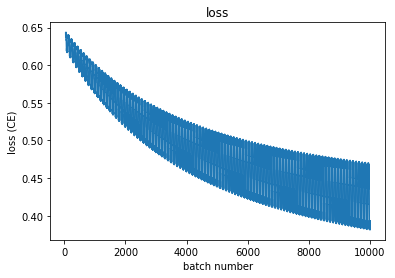

In [159]:
history = pd.DataFrame(loss_history, columns=['loss'])
history.loss.rolling(50).mean().plot()
plt.title("loss")
plt.xlabel("batch number")
plt.ylabel("loss (CE)")

In [136]:
y


tensor([[0.]])

#### Exercises
- Play with the training loop, enojoy the fact that you can inspect all the values dynamically. Consider using pdb.set_trace() for instance
- Can you edit the Perceptron class to create a Multi Layer Perceptron? (ie having more then 0 hidden layers)
- Initialize the the initial weights to 0. What do you think will happen? Can we still train the perceptron?
- What kind of gradient descnet are we using here? Stochastic? Batch? or Vanilla?
- What does detach do and why do we have to call it? (use google)
- Try adding a RELU activation after Linear unit - Will it train of not why?
- Try to implement a progress-bar (it might come in handy in our future exercises to)
 

1/7: Done


2/7: Done. Attention, plot of decision boundary not valid for MLP!


3/7: Trains and gives similar results. Network too shallow for showing downsides of zero-inits.


4/7: SGD


5/7: The detach() method constructs a new view on a tensor which is declared not to need gradients, i.e., it is to be excluded from further tracking of operations, and therefore the subgraph involving this view is not recorded. We need this to get values into numpy.


6/7: Should change loss function to one without Sigmoid. Started predicting zero class more, because negative values are "assigned" to, i. e. cut-off at zero. Keeping loss with Sigmoid: Sigmoid of zero is also zero. Never use Relu in last layer except want to regress continuous values that are always positive.


7/7: Done.

In [10]:
from IPython.display import HTML
HTML('<iframe src=https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=gauss&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=&seed=0.19214&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false width=1000 height=600></iframe>')

/opt/conda/envs/dsr/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
